In [2]:
#!/usr/bin/env python

'''
Copyright (C) 2021 Synopsys, Inc.
http://www.blackducksoftware.com/

Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements. See the NOTICE file
distributed with this work for additional information
regarding copyright ownership. The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied. See the License for the
specific language governing permissions and limitations
under the License.
 
'''
import argparse
from datetime import datetime
import json
import logging
import requests
import sys
import time

from dateutil.parser import parse # for parsing of input date/time strings

from blackduck import Client

# TODO: Refactor and put these contants into blackduck/constants in a new version of the Client lib
remediation_types = [
    'DUPLICATE',
    'IGNORED',
    'MITIGATED',
    'NEEDS_REVIEW',
    'NEW',
    'PATCHED',
    'REMEDIATION_COMPLETE',
    'REMEDIATION_REQUIRED'
]

DEFAULT_OUTPUT_FILE="vuln_remediation_report.csv"

parser = argparse.ArgumentParser("Generate a vulnerability remediation report")
parser.add_argument("base_url", help="Hub server URL e.g. https://your.blackduck.url")
parser.add_argument("token_file", help="containing access token")
parser.add_argument("projects", nargs="+", help="The list of projects to include in the report")
parser.add_argument("-s", "--start-date", dest="start_date", required=True, help="The start date for the report (required)")
parser.add_argument("-e", "--end-date", 
    dest="end_date", 
    help="The end date for the report. Default is today/now")
parser.add_argument("-f", "--format", 
    choices=['JSON', 'CSV'], 
    default='CSV',
    help="The report format (either CSV or JSON, default: CSV)")
parser.add_argument("-r", "--remediation-types", 
    dest="remediation_types", 
    default = remediation_types,
    nargs="+", 
    help=f"The remediation types which can be one or more of the following: {remediation_types}. The default is all remediation types")
parser.add_argument('-t', '--tries', default=10, type=int, help="How many times to retry downloading the report, i.e. wait for the report to be generated")
parser.add_argument("-o", "--output-file-name", 
    dest="file_name", 
    default=DEFAULT_OUTPUT_FILE, 
    help=f"Name of the output file (default: {DEFAULT_OUTPUT_FILE})")
parser.add_argument("--no-verify", 
    dest='verify', 
    action='store_false', 
    help="disable TLS certificate verification")
args = parser.parse_args("https://testing.blackduck.synopsys.com APItoken.txt webgoat-parent -s 20220101 -f CSV".split())

logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', stream=sys.stdout, level=logging.DEBUG)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("blackduck").setLevel(logging.WARNING)

class FailedReportDownload(Exception):
    pass

def download_vuln_report(bd_client, location, filename, report_format, retries=args.tries):
    if retries:
        report_status = bd_client.session.get(location).json()
        if report_status['status'] == 'COMPLETED':
            download_url = bd_client.list_resources(report_status)['download']
            contents_url = download_url + "/contents"
            report_contents = bd_client.session.get(contents_url).text.replace("..\\", "..\\\\")
            report_contents = json.loads(report_contents)
            if report_format == 'JSON':
                with open(filename, 'w') as f:
                    json.dump(report_contents, f, indent=3)
                    logging.info(f"Wrote vulnerability remediation report contents to {filename}")
            elif report_format == 'CSV':
                csv_data = report_contents['reportContent'][0]['fileContent']
                with open(filename, 'w') as f:
                    f.write(csv_data)
                    logging.info(f"Wrote vulnerability remediation report contents to {filename}")
            else:
                logging.error(f"Unrecognized format ({report_format}) given. Exiting")

        else:
            sleep_time = 15
            retries -= 1
            logging.debug(f"Report is not ready to download yet, waiting {sleep_time} seconds and then retrying {retries} more times")
            time.sleep(sleep_time)
            download_vuln_report(bd_client, location, filename, report_format, retries)
    else:
        raise FailedReportDownload(f"Failed to retrieve report from {location} after {retries} attempts")


def get_projects(client, project_names):
    '''Given a list of project names return a list of the corresponding project URLs'''
    project_urls = list()
    for project in client.get_items("/api/projects"):
        if project['name'] in project_names:
            project_urls.append(project['_meta']['href'])
    return project_urls

with open(args.token_file, 'r') as tf:
    access_token = tf.readline().strip()

bd = Client(
    base_url=args.base_url,
    token=access_token,
    verify=args.verify
)

start_date = parse(args.start_date)
end_date = parse(args.end_date) if args.end_date else datetime.now()
project_urls = get_projects(bd, args.projects)

logging.debug(f"Generating vulnerability remediation report for the following projects: {args.projects}")
logging.debug(f"start date: {start_date}, end date: {end_date}")
post_data = {
    'startDate': start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
    'reportFormat': args.format,
    'projects': project_urls,
    'locale': 'en_US'
}

if end_date:
    post_data.update({
        'endDate': end_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
        })
    
if True:
#if False:
    try:
        r = bd.session.post("/api/vulnerability-remediation-reports", json=post_data)
        r.raise_for_status()
        report_url = r.headers['Location']
        logging.debug(f"created vulnerability remediation report {report_url}")
    except requests.HTTPError as err:
        # more fine grained error handling here; otherwise:
        bd.http_error_handler(err)
        logging.error("Failed to generate the report")
        sys.exit(1)

#download_vuln_report(bd, "https://testing.blackduck.synopsys.com/api/vulnerability-reports/a48d599f-9e40-47b3-901f-d0f1235a37da", args.file_name, args.format, retries=args.tries)
#download_vuln_report(bd, "https://testing.blackduck.synopsys.com/api/vulnerability-reports/796fb82c-0734-40c9-b71a-5a61c6747c9a", args.file_name, args.format, retries=args.tries)

download_vuln_report(bd, report_url, args.file_name, args.format, retries=args.tries)









2023-03-02 17:07:12,022:DEBUG:Generating vulnerability remediation report for the following projects: ['webgoat-parent']
2023-03-02 17:07:12,022:DEBUG:start date: 2022-01-01 00:00:00, end date: 2023-03-02 17:07:06.325070
2023-03-02 17:07:12,295:DEBUG:created vulnerability remediation report https://testing.blackduck.synopsys.com/api/vulnerability-reports/a03d4f9f-c5d1-4dae-9249-e6e6cb0e1351
2023-03-02 17:07:12,537:DEBUG:Report is not ready to download yet, waiting 15 seconds and then retrying 9 more times
2023-03-02 17:07:31,607:DEBUG:utf-8  confidence = 0.99
2023-03-02 17:07:31,607:DEBUG:SHIFT_JIS Japanese confidence = 0.01
2023-03-02 17:07:31,608:DEBUG:EUC-JP Japanese confidence = 0.01
2023-03-02 17:07:31,608:DEBUG:GB2312 Chinese confidence = 0.01
2023-03-02 17:07:31,609:DEBUG:EUC-KR Korean confidence = 0.01
2023-03-02 17:07:31,609:DEBUG:CP949 Korean confidence = 0.01
2023-03-02 17:07:31,611:DEBUG:Big5 Chinese confidence = 0.01
2023-03-02 17:07:31,611:DEBUG:EUC-TW Taiwan confidence =

In [3]:
import pandas as pd
import pdfkit

# SAVE CSV TO HTML USING PANDAS
csv_file = 'vuln_remediation_report.csv'
html_file = csv_file[:-3]+'html'

df = pd.read_csv(csv_file, sep=',', engine='python')

In [4]:
df["Remediation status"].value_counts()

NEW             1080
IGNORED           66
NEEDS_REVIEW       8
Name: Remediation status, dtype: int64

In [5]:
df = df[df["Version"]=="8.2.0"]
df["Remediation status"].value_counts()

NEW             401
IGNORED          22
NEEDS_REVIEW      4
Name: Remediation status, dtype: int64

2023-03-02 17:08:55,700:DEBUG:(private) matplotlib data path: C:\Users\chanp\Anaconda3\lib\site-packages\matplotlib\mpl-data
2023-03-02 17:08:55,701:DEBUG:matplotlib data path: C:\Users\chanp\Anaconda3\lib\site-packages\matplotlib\mpl-data
2023-03-02 17:08:55,706:DEBUG:CONFIGDIR=C:\Users\chanp\.matplotlib
2023-03-02 17:08:55,709:DEBUG:matplotlib version 3.3.2
2023-03-02 17:08:55,709:DEBUG:interactive is False
2023-03-02 17:08:55,710:DEBUG:platform is win32
2023-03-02 17:08:55,710:DEBUG:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'nt', '_thread', '_weakref', 'winreg', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importli

2023-03-02 17:08:55,769:DEBUG:CACHEDIR=C:\Users\chanp\.matplotlib
2023-03-02 17:08:55,773:DEBUG:Using fontManager instance from C:\Users\chanp\.matplotlib\fontlist-v330.json
2023-03-02 17:08:56,034:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2023-03-02 17:08:56,035:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2023-03-02 17:08:56,102:DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-03-02 17:08:56,103:DEBUG:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,104:DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,104:DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,105:DEBUG:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.0

2023-03-02 17:08:56,131:DEBUG:findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,132:DEBUG:findfont: score(<Font 'Century' (CENTURY.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,132:DEBUG:findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,132:DEBUG:findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,133:DEBUG:findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,133:DEBUG:findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
2023-03-02 17:08:56,133:DEBUG:findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,134:DEBUG:findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,134:DEBUG:findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal 7

2023-03-02 17:08:56,158:DEBUG:findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,159:DEBUG:findfont: score(<Font 'Constantia' (constanb.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,159:DEBUG:findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2023-03-02 17:08:56,159:DEBUG:findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
2023-03-02 17:08:56,160:DEBUG:findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,160:DEBUG:findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,160:DEBUG:findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,161:DEBUG:findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,161:DEBUG:findfont: score(<Font 'Segoe UI' (segoeuisl.

2023-03-02 17:08:56,184:DEBUG:findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,184:DEBUG:findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,185:DEBUG:findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,185:DEBUG:findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
2023-03-02 17:08:56,186:DEBUG:findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,186:DEBUG:findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,186:DEBUG:findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,187:DEBUG:findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
2023-03-02 17:08:56,187:DEBUG:findfont: score(<Font 'Microsoft Tai Le'

2023-03-02 17:08:56,214:DEBUG:findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,214:DEBUG:findfont: score(<Font 'Corbel' (corbell.ttf) normal normal 300 normal>) = 10.145
2023-03-02 17:08:56,215:DEBUG:findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
2023-03-02 17:08:56,215:DEBUG:findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,215:DEBUG:findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal 500 normal>) = 10.145
2023-03-02 17:08:56,216:DEBUG:findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,216:DEBUG:findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,216:DEBUG:findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,216:DEBUG:findfont: score(<Font 'Century Gothi

2023-03-02 17:08:56,240:DEBUG:findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal 700 normal>) = 11.335
2023-03-02 17:08:56,241:DEBUG:findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
2023-03-02 17:08:56,241:DEBUG:findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
2023-03-02 17:08:56,242:DEBUG:findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,242:DEBUG:findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal 700 normal>) = 11.335
2023-03-02 17:08:56,242:DEBUG:findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,243:DEBUG:findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,243:DEBUG:findfont: score(<Font 'Segoe Condensed' (segoe.ttf) normal normal 400 condensed>) = 10.25
2023-03-02 17:08:56,244:DEBUG:findfont: score(<Font 'Lucida Han

2023-03-02 17:08:56,270:DEBUG:findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,270:DEBUG:findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal 300 normal>) = 11.145
2023-03-02 17:08:56,271:DEBUG:findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal 600 normal>) = 11.24
2023-03-02 17:08:56,271:DEBUG:findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal 500 normal>) = 10.145
2023-03-02 17:08:56,271:DEBUG:findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
2023-03-02 17:08:56,272:DEBUG:findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal 700 normal>) = 10.335
2023-03-02 17:08:56,272:DEBUG:findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
2023-03-02 17:08:56,282:DEBUG:findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal 700 normal>) = 3.9713636363636367
2023-03-02 17:08:56,282:DEBUG:findfont: score(<Font 'Cambria' 

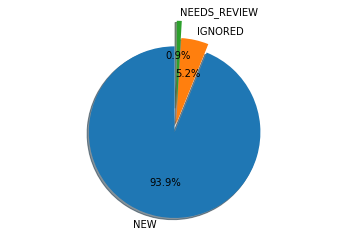

In [6]:
import matplotlib.pyplot as plt
vc = df["Remediation status"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(vc.values, labels=vc.index, explode=(0.1,0,0.2), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
fig1.savefig('vuln_med.png')

In [7]:
df_ss = df[["Project name", "Version", "Component name", "Component origin id", "Vulnerability id", "Security Risk", "Remediation status", "Remediation updated at"]]
df_ss.index += 1 

2023-03-02 17:09:14,782:INFO:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-03-02 17:09:14,783:INFO:NumExpr defaulting to 8 threads.


In [8]:
df_ss.to_html(html_file)

with open(html_file, "r") as f:
    contents = f.readlines()

contents.insert(0, '<p style="text-align:center;"><img src="file:///C:\\Users\\chanp\\SE\\Setup\\BD\\vuln_med.png" alt="pie"></p>')

with open(html_file, "w") as f:
    f.writelines(contents)
    


In [9]:


# INSTALL wkhtmltopdf AND SET PATH IN CONFIGURATION
# These two Steps could be eliminated By Installing wkhtmltopdf -
# - and setting it's path to Environment Variables
options = {'enable-local-file-access': None}

path_wkhtmltopdf = r'C:\Users\chanp\SE\Setup\BD\wkhtmltox-0.12.6-1.mxe-cross-win64\wkhtmltox\bin\wkhtmltopdf.exe'
config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)

# CONVERT HTML FILE TO PDF WITH PDFKIT
pdfkit.from_file("vuln_remediation_report.html", "vuln_remediation_report.pdf", configuration=config, options=options)


True